In [22]:
import numpy as np
from matplotlib import pyplot as plt

# Methods for cross-section parameters

In [23]:
def get_cross_section_parameters_circular(d, D, E, fy):
    """ Gets parameters for a full circular cross-sections
    d: steel bar diameter [mm]
    D: pile shaft diameter [mm]
    E: Young's modulus of steel [N/mm^2]
    fy: characteristic yield stress [N/mm^2]
    fyA: characteristic resistance of the full cross-section [kN]
    """
    A = np.pi/4*d**2		    # [mm^2]
    I = np.pi/4*(d*0.1/2)**4	# [cm^4]
    EI = E*I*1.0e-5		        # [kNm^2]
    fyA = fy*A*1.0e-3		    # [kN]
    return A, I, EI, fyA

def get_cross_section_parameters_tube(d, t, D, E, fy):
    """ Gets parameters for a hollow tube cross-section
    d: steel bar diameter [mm]
    t: thickness of the steel tube
    D: pile shaft diameter [mm]
    E: Young's modulus of steel [N/mm^2]
    fy: characteristic yield stress [N/mm^2]
    fyA: characteristic resistance of the full cross-section [kN]
    """
    A = np.pi*((d/2)**2 - ((d-2*t)/2)**2)	            # [mm^2]
    I = np.pi/4*((d*0.1/2)**4 - ((d-2*t)*0.1/2)**4)	    # [cm^4]
    EI = E*I*1.0e-5		                        # [kNm^2]
    fyA = fy*A*1.0e-3		                    # [kN]
    return A, I, EI, fyA

# Methods for p-y curves

In [24]:
def get_w_f_elastoplastic_eq1(D, c_u):
    """ Gets pile lateral displacement at yield (p-y curve)
    c_u: soil undrained shear strength [kN/m^2]
    D: pile shaft diameter
    """
    w_f = 0.2/(c_u**0.4)*D
    return w_f

def get_p_f_elastoplastic_eq2(c_u):
    """ Gets stress from lateral soil resistance at yield (p-y curve)
    This approximation is used for piles having smooth surface.
    Formula from Randolph and Houlsby. The limitting pressure on a circular pile loaded laterally in cohesive soil. Geotechnique 34 (1984).
    """
    p_f = (6 + np.pi)*c_u
    return p_f # kN/m^2

def get_p_f_elastoplastic_eq3(c_u):
    """ Gets stress from lateral soil resistance at yield (p-y curve)
    This approximation is used for piles having rough surface.
    Formula from Randolph and Houlsby. The limitting pressure on a circular pile loaded laterally in cohesive soil. Geotechnique 34 (1984).
    """
    p_f = (4*2*0.5 + 2*np.pi)*c_u
    return p_f # kN/m^2

def get_p_f_elastoplastic_eq4(c_u):
    """ Gets stress from lateral soil resistance at yield (p-y curve)
    This approximation is used for piles with potenial damages: the circumferential contact between soil and pile is not full.
    Formula from Wenz. Das Knicken von schlanken Pfählen in weichen bindigen Erdstoffen. Institute für Bodenmechnik und Felsmechanik Universität Fridericiana Karlsruhe 1972.
    """
    p_f = (2 + 2*np.pi)*c_u
    return p_f # kN/m^2

# Methods for bifurcation load
Vogt, N., & Vogt, S. (2013). Biegeknickwiderstand von Mikropfählen gemäß den Eurocodes. Bautechnik, 90(9), 550-558.

In [25]:
def e0_eq8(Lcr,k_imp):
    """Calculates predeformaion with Lcr"""
    e0 = (Lcr/2)* np.tan(0.5*np.arcsin(Lcr/2*(k_imp)))
    return e0

def N_cr_eq7(w_f, EI, p_f, D, k_imp, Lcr):
    """Calculates Branching Load Ncr"""
    e0 = e0_eq8(Lcr,k_imp)
    Ncr = ((w_f*EI*(np.pi/Lcr)**2)+(p_f*D*(Lcr/np.pi)**2))/(w_f+e0)
    return Ncr

def get_Ncr_by_iteration(w_f, EI, p_f, D, k_imp, L):
    """ Calculates the Lcr to achieve minimum value of Ncr
    EI : Modulus of elasiticty multiplied by moment of Inertia of the bar
    L: Lenth of the driven pile [m]
    w_f: pile laterial deflection [m]
    D: pile shaft diameter [m]
    """
    L_step = L/50
    Lcr = L_step;Ncr = 10**20
    while Lcr < L:
        temp = N_cr_eq7(w_f, EI, p_f, D, k_imp, Lcr)
        if temp<Ncr:
            Ncr = temp
            Lcrd = Lcr
        Lcr += L_step
    return (Lcrd, Ncr)

# Methods for bucking resistance following EC3
The value for imperfection factor alpha is dependent on the applied buckling curve.
<img src="figs/imperfection_factor_alpha_EC3.png">

In [26]:
"""DIN EN 1993 1-1 Table 6.1, please refer Table 6.2 in DIN EN 1993 1-1 for classification of Buckling classes"""
ALPHA_BUCKLING_CURVES = {'a0': 0.13, 'a':0.21, 'b':0.34, 'c':0.49, 'd':0.76}

def get_slenderness_lambda(fyA, Ncr):
    """Gets the non-dimensional slenderness lambda"""
    lambda_ = (fyA/Ncr)**0.5
    return lambda_

def get_phi_factor(lambda_, buckling_curve='c'):
    """ Gets the phi factor"""
    alpha = ALPHA_BUCKLING_CURVES[buckling_curve]
    phi = 0.5*(1+(alpha*(lambda_ - 0.2)) + lambda_**2)
    return phi

def get_reduction_factor_psi(phi, lambda_):
    """ Gets the reduction factor psi"""
    psi = 1/(phi+(phi**2-lambda_**2)**0.5)
    return psi

def get_buckling_resistance(psi, fyA, gamma_M=1.1):
    """ Gets the cross-sectional buckling resistance"""
    Nb_Rd = psi*fyA/gamma_M
    return Nb_Rd

def get_Nb_Rd_EC3(fyA, Ncr, buckling_curve='c', gamma_M=1.1):
    """ get cross-sectional buckling resistance after EC3"""
    lambda_ = get_slenderness_lambda(fyA, Ncr)
    phi = get_phi_factor(lambda_, buckling_curve)
    psi = get_reduction_factor_psi(phi, lambda_)
    Nb_Rd = get_buckling_resistance(psi, fyA, gamma_M)
    return Nb_Rd

def get_Nb_Rd_DIBt(L, D, EI, fyA, c_u, buckling_curve='c', gamma_M=1.1):
    """ get cross-sectional buckling resistance after DIBt-Zulassung
    D: pile shaft diameter [mm]"""
    p_f = 6*c_u             # [kN/m^2]
    w_f = 0.1*D             # [mm]
    k_imp = 1/200	        # [m]
    Lcr, Ncr = get_Ncr_by_iteration(w_f*0.001, EI, p_f, D*0.001, k_imp, L)
    if c_u < 10:    # no lateral soil support
        Ncr = EI*(np.pi/L)**2
        Nb_Rd = get_Nb_Rd_EC3(fyA, Ncr, buckling_curve, gamma_M)
    elif c_u <= 30:
        Nb_Rd = get_Nb_Rd_EC3(fyA, Ncr, buckling_curve, gamma_M)
    else:
        Nb_Rd = fyA/gamma_M
    return Nb_Rd

# Putting things together

In [27]:
def display_micropile_buckling_resistance(D, EI, fyA, k_imp, L, p_f, c_u, Nb_Rd, buckling_curve, gamma_M):
    """ Gets final results"""
    # Data generation and plotting
    c_u_array = np.linspace(1, 120, 120)
    w_f_array = get_w_f_elastoplastic_eq1(D, c_u_array)
    p_f_array = get_p_f_elastoplastic_eq2(c_u_array)
    Ncr_array = np.zeros_like(c_u_array)
    Nb_Rd_EC3_array = np.zeros_like(c_u_array)
    Nb_Rd_DIBt_array = np.zeros_like(c_u_array)
    #print(Ncr_array)
    for i in range(Ncr_array.size):
        _, Ncr_i = get_Ncr_by_iteration(w_f_array[i]*0.001, EI, p_f_array[i], D*0.001, k_imp, L)
        Ncr_array[i] = Ncr_i
    
        # get cross-sectional buckling resistance after EC3
        Nb_Rd_EC3_i = get_Nb_Rd_EC3(fyA, Ncr_i, buckling_curve, gamma_M=1.1)
        Nb_Rd_DIBt_i = get_Nb_Rd_DIBt(L, D, EI, fyA, c_u_array[i], buckling_curve, gamma_M=1.1)
        Nb_Rd_EC3_array[i] = Nb_Rd_EC3_i
        Nb_Rd_DIBt_array[i] = Nb_Rd_DIBt_i
    
    #print(Nb_Rd_array)
    
    fig, ax = plt.subplots()
    ax.plot(c_u_array, Nb_Rd_EC3_array, c='orange', label='calculated')
    ax.plot(c_u_array, Nb_Rd_DIBt_array, c='blue', label='DIBt-Zulassung')
    ax.legend()
    ax.scatter(c_u, Nb_Rd, c='red')
    ax.set_title("1/kappa = {0:.0f} [m]; p_f = {1:.1f} * c_u; buckling curve='{2}'".format(1/k_imp, p_f/c_u, buckling_curve))
    ax.set_xlabel('Undrained shear strength c_u [kN/m^2]')
    ax.set_ylabel('Design resistance against bucking Nb_Rd [kN]')

# Example 1
Vogt, S., & Vogt, N. (2013). Nachweis zum Biegeknickwiderstand im drainierten und undrainierten Fall sowie im Fall Seitendruck.

CROSS-SECTIONAL PARAMETERS
A = 1963.50 [mm^2]; I = 30.68 [cm^4]; EI = 61.36 [kNm^2]; fyA = 981.75 [kN]

MAXIMAL MOBILIZED LATERAL DISPLACEMENT AND STRESS (SOIL-PILE INTERACTION)
c_u = 10.00 [kN/m^2]
w_f = 21.50 [mm]
p_f = 105.00 [kN/m^2]

DESIGN RESISTANCE AGAINST BUCKLING
Lcr = 1.44 [m]; Ncr = 536.76 [kN]
Nb_Rd = 327.92 [kN]


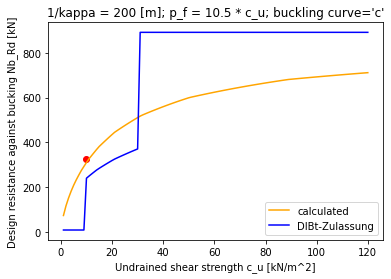

In [28]:
d, D, E, fy = 50, 270, 200000, 500
A, I, EI, fyA = get_cross_section_parameters_circular(d, D, E, fy)
print('CROSS-SECTIONAL PARAMETERS')
print('A = {0:.2f} [mm^2]; I = {1:.2f} [cm^4]; EI = {2:.2f} [kNm^2]; fyA = {3:.2f} [kN]\n'.format(A, I, EI, fyA))

# Seeton, undrained shear strength c_u = 10 kN/m^2
c_u = 10 # kN/m^2
w_f = get_w_f_elastoplastic_eq1(D, c_u)
#p_f = get_p_f_elastoplastic_eq2(c_u)
p_f = 10.5*c_u
print('MAXIMAL MOBILIZED LATERAL DISPLACEMENT AND STRESS (SOIL-PILE INTERACTION)')
print('c_u = {0:.2f} [kN/m^2]'.format(c_u))
print('w_f = {0:.2f} [mm]'.format(w_f))
print('p_f = {0:.2f} [kN/m^2]\n'.format(p_f))

# Micropile length and buckling parameters
L = 8 		# [m]
k_imp = 1/200	# [m]
buckling_curve = 'c'    # {a0, a, b, c, d}, buckling curves in Figure 6.4, EC3
gamma_M = 1.1

# Buckling resistance check for the given c_u value
Lcr, Ncr = get_Ncr_by_iteration(w_f*0.001, EI, p_f, D*0.001, k_imp, L)
# get cross-sectional buckling resistance after EC3
Nb_Rd = get_Nb_Rd_EC3(fyA, Ncr, buckling_curve, gamma_M)
print('DESIGN RESISTANCE AGAINST BUCKLING')
print('Lcr = {0:.2f} [m]; Ncr = {1:.2f} [kN]'.format(Lcr, Ncr))
print('Nb_Rd = {0:.2f} [kN]'.format(Nb_Rd))

# Data generation and plotting
display_micropile_buckling_resistance(D, EI, fyA, k_imp, L, p_f, c_u, Nb_Rd, buckling_curve, gamma_M)


# Example 2
Vogt, S., & Vogt, N. (2013). Nachweis zum Biegeknickwiderstand im drainierten und undrainierten Fall sowie im Fall Seitendruck.

In [29]:
d, t, D, E, fy = 273, 8, 273, 210000, 420
A, I, EI, fyA = get_cross_section_parameters_tube(d, t, D, E, fy)
print('CROSS-SECTIONAL PARAMETERS')
print('A = {0:.2f} [mm^2]; I = {1:.2f} [cm^4]; EI = {2:.2f} [kNm^2]; fyA = {3:.2f} [kN]\n'.format(A, I, EI, fyA))

# Seeton, undrained shear strength c_u = 10 kN/m^2
c_u = 10 # kN/m^2
w_f = get_w_f_elastoplastic_eq1(D, c_u)
#p_f = get_p_f_elastoplastic_eq2(c_u)
p_f = 10.5*c_u
print('MAXIMAL MOBILIZED LATERAL DISPLACEMENT AND STRESS (SOIL-PILE INTERACTION)')
print('c_u = {0:.2f} [kN/m^2]'.format(c_u))
print('w_f = {0:.2f} [mm]'.format(w_f))
print('p_f = {0:.2f} [kN/m^2]\n'.format(p_f))

# Micropile length and buckling parameters
#L = 15 		# [m]
#k_imp = 1/200	# [m]
buckling_curve = 'a'    # {a0, a, b, c, d}, buckling curves in Figure 6.4, EC3

# Buckling resistance check for the given c_u value
Lcr = 8 # lateral soil support is not considered
Ncr = EI*(np.pi/Lcr)**2
# get cross-sectional buckling resistance after EC3
Nb_Rd = get_Nb_Rd_EC3(fyA, Ncr, buckling_curve, gamma_M=1.1)
print('DESIGN RESISTANCE AGAINST BUCKLING')
print('Lcr = {0:.2f} [m]; Ncr = {1:.2f} [kN]'.format(Lcr, Ncr))
print('Nb_Rd = {0:.2f} [kN]'.format(Nb_Rd))

CROSS-SECTIONAL PARAMETERS
A = 6660.18 [mm^2]; I = 5851.71 [cm^4]; EI = 12288.60 [kNm^2]; fyA = 2797.27 [kN]

MAXIMAL MOBILIZED LATERAL DISPLACEMENT AND STRESS (SOIL-PILE INTERACTION)
c_u = 10.00 [kN/m^2]
w_f = 21.74 [mm]
p_f = 105.00 [kN/m^2]

DESIGN RESISTANCE AGAINST BUCKLING
Lcr = 8.00 [m]; Ncr = 1895.06 [kN]
Nb_Rd = 1323.97 [kN]
